### 测试

In [ ]:
from utils.dataset_utils import get_distribution, remove_class
from instance_selection.parameter.parameter import *  # 导入参数的设定
from instance_selection.operator.init_toolbox import init_toolbox_emosaic
from instance_selection.operator.metrics import calculate_gmean_mauc, calculate_average_gmean_mauc
from instance_selection.operator.genetic_operator import selTournamentNDCD
from instance_selection.operator.ensemble import vote_result_ensembles, ensemble_individuals
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scipy.io as sio  # 从.mat文件中读取数据集
import random
from deap import tools
import warnings

warnings.filterwarnings("ignore")  # 忽略警告

datasetname = 'Satimage.mat'
mat_data = sio.loadmat('../datasets/mat/raw_data/' + datasetname)

x = mat_data['X']
y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
x,y=remove_class(x,y,2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)  # 划分数据集
scaler = StandardScaler()  # 数据的标准化
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
unique_elements_all, classes_all, counts_all = get_distribution(y)  # 获取原始数据集分布
unique_elements_train, classes_train, counts_train = get_distribution(y_train)  # 获取训练集分布
unique_elements_test, classes_test, counts_test = get_distribution(y_test)  # 获取测试集分布
print(datasetname + f' distribution: {counts_all}')
print(f'trainset distribution: {counts_train}')
print(f'testset distribution: {counts_test}')


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
from scipy.io import savemat
# 保存为 .mat 文件
data_dict = {'X': x, 'Y': y.reshape(-1, 1)}  # 以字典形式存储
savemat(datasetname, data_dict)
# 输出保存成功
print("数据保存成功！")

In [ ]:
import numpy as np


def ensure_min_samples(X, Y, ind, min_samples=5):
    """
    确保ind中选择的实例，每个类别至少有min_samples个，
    若不足，则从未选择的实例中补充。
    
    :param X: 实例数据，形状为 (n_samples, n_features)
    :param Y: 标签数据，形状为 (n_samples,)
    :param ind: 选择序列，形状为 (n_samples,)
    :param min_samples: 每个类别的最小选择样本数
    :return: 更新后的选择序列 ind
    """
    ind = np.array(ind)
    Y = np.array(Y)

    unique_classes = np.unique(Y)

    for cls in unique_classes:
        selected_indices = np.where((ind == 1) & (Y == cls))[0]
        unselected_indices = np.where((ind == 0) & (Y == cls))[0]

        if len(selected_indices) < min_samples:
            num_needed = min_samples - len(selected_indices)
            if len(unselected_indices) >= num_needed:
                additional_indices = np.random.choice(unselected_indices, num_needed, replace=False)
            else:
                additional_indices = unselected_indices  # 如果不足，则全选

            ind[additional_indices] = 1

    return ind


# 示例数据
X = np.random.rand(20, 5)  # 20个实例，每个实例5个特征
Y = np.random.randint(0, 4, 20)  # 20个实例的标签，类别为 0,1,2,3
ind = np.random.choice([0, 1], size=20, p=[0.7, 0.3])  # 随机选择部分实例

updated_ind = ensure_min_samples(X, Y, ind, min_samples=5)
print("更新后的选择序列:", updated_ind)


In [ ]:
import pandas as pd

# 数据
gmean_data = [
    [0.867204, 0.706186, 0.90059, 0.895197, 0.886062, 0.90059],
    [0.867204, 0.821475, 0.886062, 0.90059, 0.914664, 0.90059],
    [0.867204, 0.734127, 0.886062, 0.886062, 0.914664, 0.886062],
    [0.867204, 0.638961, 0.886062, 0.914664, 0.895197, 0.867204],
    [0.867204, 0.798275, 0.886062, 0.867204, 0.895197, 0.852503],
    [0.867204, 0.593159, 0.886062, 0.90059, 0.914664, 0.881423],
    [0.867204, 0.697358, 0.886062, 0.0, 0.895197, 0.871041],
    [0.867204, 0.633592, 0.886062, 0.871041, 0.895197, 0.90059],
    [0.867204, 0.786738, 0.886062, 0.881423, 0.881423, 0.895197],
    [0.867204, 0.740789, 0.90059, 0.881423, 0.90059, 0.0],
    [0.867204, 0.755039, 0.886062, 0.881423, 0.933336, 0.0],
    [0.867204, 0.703268, 0.0, 0.881423, 0.881423, 0.886062],
    [0.867204, 0.847488, 0.886062, 0.895197, 0.914664, 0.881423],
    [0.867204, 0.703268, 0.0, 0.881423, 0.881423, 0.886062],
    [0.867204, 0.734127, 0.886062, 0.881423, 0.895197, 0.871041],
    [0.867204, 0.743421, 0.886062, 0.881423, 0.914664, 0.90059],
    [0.867204, 0.0, 0.90059, 0.881423, 0.895197, 0.867204],
    [0.867204, 0.0, 0.886062, 0.90059, 0.895197, 0.914664],
    [0.867204, 0.837276, 0.886062, 0.895197, 0.914664, 0.881423],
    [0.867204, 0.725969, 0.886062, 0.881423, 0.90059, 0.867204],
    [0.867204, 0.0, 0.886062, 0.90059, 0.914664, 0.895197]
]

mauc_data = [
    [0.953261, 0.919928, 0.965217, 0.950362, 0.957609, 0.942754],
    [0.953261, 0.908696, 0.943116, 0.947101, 0.967029, 0.94529],
    [0.953261, 0.868478, 0.952174, 0.947826, 0.963406, 0.941304],
    [0.953261, 0.766667, 0.961957, 0.940217, 0.95471, 0.933333],
    [0.953261, 0.919565, 0.923188, 0.91558, 0.967029, 0.938768],
    [0.953261, 0.747464, 0.944203, 0.931159, 0.956522, 0.946377],
    [0.953261, 0.855072, 0.955435, 0.92971, 0.969928, 0.940217],
    [0.953261, 0.869565, 0.956522, 0.944928, 0.969928, 0.92971],
    [0.953261, 0.906884, 0.937681, 0.950362, 0.952536, 0.955435],
    [0.953261, 0.876812, 0.965217, 0.961957, 0.968116, 0.947826],
    [0.953261, 0.924275, 0.951087, 0.929348, 0.957609, 0.951449],
    [0.953261, 0.806159, 0.903623, 0.955072, 0.965942, 0.948913],
    [0.953261, 0.943116, 0.956884, 0.952536, 0.977536, 0.953986],
    [0.953261, 0.806159, 0.903623, 0.955072, 0.965942, 0.948913],
    [0.953261, 0.922826, 0.962681, 0.928261, 0.967754, 0.922826],
    [0.953261, 0.872101, 0.949275, 0.946377, 0.949275, 0.927174],
    [0.953261, 0.658696, 0.968841, 0.960507, 0.963406, 0.94058],
    [0.953261, 0.832971, 0.96413, 0.948551, 0.963768, 0.955435],
    [0.953261, 0.942754, 0.953623, 0.955435, 0.961957, 0.950725],
    [0.953261, 0.91558, 0.936232, 0.951087, 0.939493, 0.943841],
    [0.953261, 0.83442, 0.92971, 0.930072, 0.958333, 0.942029]
]

# 创建DataFrame
gmean_df = pd.DataFrame(gmean_data, columns=[f"Gmean_{i + 1}" for i in range(6)])
gmean_df.insert(0, "Run", [f"第{i + 1}次运行" for i in range(len(gmean_data))])

mauc_df = pd.DataFrame(mauc_data, columns=[f"mAUC_{i + 1}" for i in range(6)])
mauc_df.insert(0, "Run", [f"第{i + 1}次运行" for i in range(len(mauc_data))])

# 保存到Excel文件
output_path = "Gmean_MAUC.xlsx"
with pd.ExcelWriter(output_path) as writer:
    gmean_df.to_excel(writer, sheet_name="Gmean", index=False)
    mauc_df.to_excel(writer, sheet_name="MAUC", index=False)

output_path


In [ ]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
for i in range(len(a)):
    a[i] = a[i] + 1
print(a)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

# 设置seaborn风格（无网格）
sns.set(style="white", font_scale=1.2)

# 模拟数据（4类，每类20-40个点）
np.random.seed(42)
X = []
y = []
for label in range(4):
    num_points = np.random.randint(20, 41)
    center = np.random.uniform(-5, 5, size=2) * 3
    points = np.random.randn(num_points, 2) + center
    X.append(points)
    y.append(np.full(num_points, label))

X = np.vstack(X)
y = np.concatenate(y)

# 拟合模型
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X, y)

# 决策边界网格
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 配色方案
palette = sns.color_palette("Set2", 4)

# 绘图
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, levels=np.arange(-0.5, 4), colors=palette)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette, s=80, edgecolor='k', linewidth=0.8)

# 标题与图例
plt.title("分类模型决策边界图", fontsize=16)
plt.legend(title="类别", loc='upper right')

# 去掉坐标轴 & 边框
plt.axis('off')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


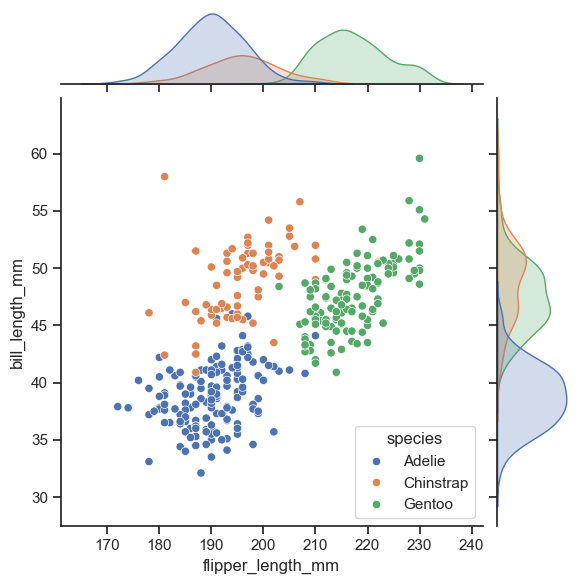

In [11]:
# Import seaborn
import seaborn as sns
penguins = sns.load_dataset("penguins")
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")

D:\IDE\Anaconda\envs\pytorch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


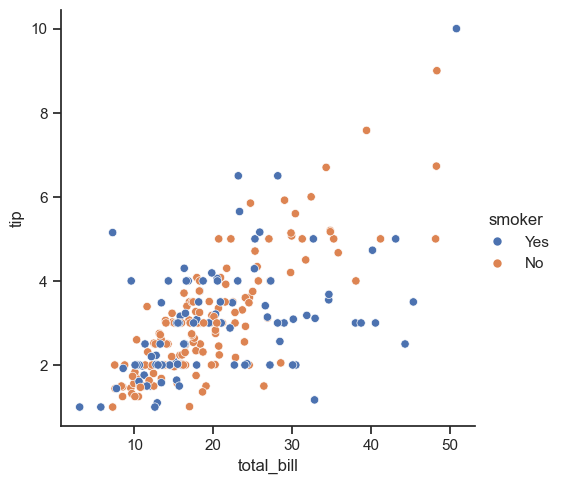

In [12]:
tips = sns.load_dataset("tips")
sns.relplot(data=tips, x="total_bill", y="tip", hue="smoker")